In [ ]:
import time
import numpy as np
from gep_config_parser import *
from data_wrangling import dataframe_to_dict
import pyomo.environ as pyo

from gep_main import run_model, prep_data, run_model_no_bounds
from old_gep_code.gep_problem import GEPProblem

import torch

DTYPE = torch.float64

torch.set_default_dtype(DTYPE)

# DEVICE = (
#     torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# )

DEVICE = "cpu"

Parsing the config file
Initializing the solver
Using Gurobi


In [2]:
CONFIG_FILE_NAME        = "config.toml"
VISUALIZATION_FILE_NAME = "visualization.toml"

HIGHS  = "HiGHS"
GUROBI = "Gurobi"

SAMPLE_DURATION = 12 # 12 hours

## Step 0: Activate environment - ensure consistency accross computers
# print("Reading the data")
# print("Activating the environment")


In [3]:

## Step 1: parse the input data
print("Parsing the config file")

data = parse_config(CONFIG_FILE_NAME)
experiment = data["experiment"]
outputs_config = data["outputs_config"]

print("Initializing the solver")
optimizer_name = data["optimizer_config"]["solver"]

# Determine the optimizer
if optimizer_name == HIGHS:
    raise NotImplementedError(f"{optimizer_name}: Not implemented")
elif optimizer_name == GUROBI:
    
    print(f"Using {GUROBI}")
    optimizer = "gurobi_direct"
else:
    raise ValueError(f"{optimizer_name}: Not implemented")

Parsing the config file
Initializing the solver
Using Gurobi


In [4]:
for i, experiment_instance in enumerate(experiment["experiments"]):
    # Setup output dataframe
    df_res = pd.DataFrame(columns=["setup_time", "presolve_time", "barrier_time", "crossover_time", "restore_time", "objective_value"])

    input_T, input_N, input_G, input_L, input_pDemand, input_pGenAva, input_pVOLL, input_pWeight, input_pRamping, input_pInvCost, input_pVarCost, input_pUnitCap, input_pExpCap, input_pImpCap = prep_data(experiment_instance)

    T_ranges = [range(i, i + SAMPLE_DURATION, 1) for i in range(1, len(input_T), SAMPLE_DURATION)]
    objective_values = []
    times = []
    models = []
    solvers = []
    for t in T_ranges[:1]:
        # Run one experiment for j repeats
        model, solver, time_taken = run_model(experiment_instance, t, input_N, input_G, input_L, input_pDemand, input_pGenAva, input_pVOLL, input_pWeight, input_pRamping, input_pInvCost, input_pVarCost, input_pUnitCap, input_pExpCap, input_pImpCap)
        models.append(model)
        solvers.append(solver)

Wrangling the input data
Populating the model
Adding model variables
Formulating the objective
Adding model constraints
Solving the optimization problem
Set parameter OutputFlag to value 1
Set parameter LogFile to value "outputs/Gurobi/output.txt"
Set parameter Crossover to value 0
Set parameter FeasibilityTol to value 1e-09
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 22.3.0 22D49)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Non-default parameters:
FeasibilityTol  1e-09
Method  2
Crossover  0
QCPDual  1

Optimize a model with 140 rows, 113 columns and 467 nonzeros
Model fingerprint: 0x93c00021
Coefficient statistics:
  Matrix range     [7e-02, 2e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+03, 3e+04]
  RHS range        [4e+03, 3e+04]
Presolve removed 126 rows and 104 columns
Presolve time: 0.00s
Presolved: 14 rows, 9 columns, 42 nonzeros
Ordering time

In [5]:
GEP_data = GEPProblem(input_T, input_N, input_G, input_L, input_pDemand, input_pGenAva, input_pVOLL, input_pWeight, input_pRamping, input_pInvCost, input_pVarCost, input_pUnitCap, input_pExpCap, input_pImpCap, sample_duration=SAMPLE_DURATION, shuffle=False)
GEP_X = GEP_data.trainX

Size of train set: 584
Size of val set: 73
Size of test set: 73
Size of mu: 285
Size of lambda: 36
Number of variables (size of y): 111
Number of inputs (size of X): 72


In [6]:
import pickle

filepath = "./CUSTOM_random_simple_dataset_var100_ineq50_eq50_ex10"

with open(filepath, 'rb') as f:
    QP_data = pickle.load(f)

for attr in dir(QP_data):
    var = getattr(QP_data, attr)
    if not callable(var) and not attr.startswith("__") and torch.is_tensor(var):
        try:
            setattr(QP_data, attr, var.to(dtype=torch.float64, device=DEVICE))
        except AttributeError:
            pass
QP_data._device = DEVICE

QP_X = QP_data.trainX

FileNotFoundError: [Errno 2] No such file or directory: './CUSTOM_random_simple_dataset_var100_ineq50_eq50_ex10'

In [ ]:
print(GEP_X.shape)

print(QP_X.shape)

torch.Size([584, 72])
torch.Size([8, 100])


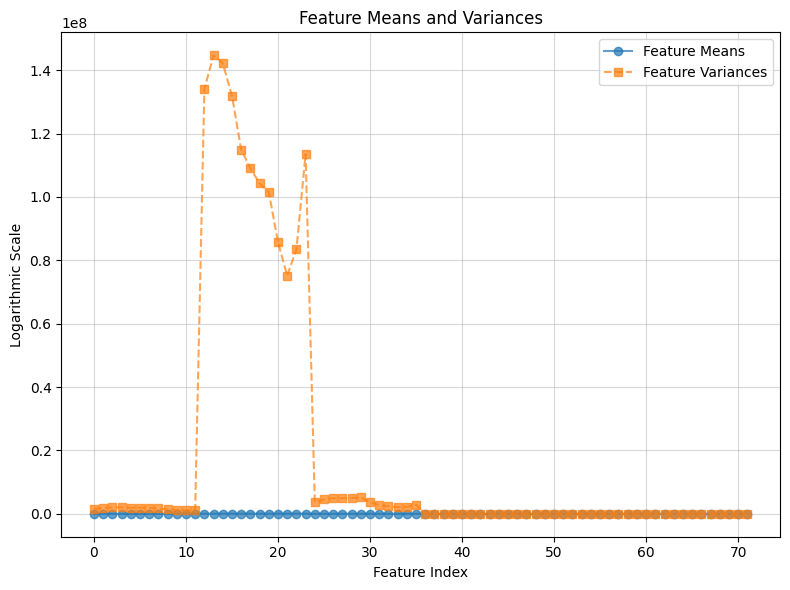

In [11]:
import matplotlib.pyplot as plt
GEP_means = torch.mean(GEP_X, axis=0)
GEP_vars = torch.var(GEP_X, axis=0)

# Plot the means and variances of all features on the same figure with a logarithmic Y-axis
plt.figure(figsize=(8, 6))
plt.plot(GEP_means, label='Feature Means', marker='o', linestyle='-', alpha=0.7)
plt.plot(GEP_vars, label='Feature Variances', marker='s', linestyle='--', alpha=0.7)
# plt.yscale('log')
plt.title('Feature Means and Variances')
plt.xlabel('Feature Index')
plt.ylabel('Logarithmic Scale')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
GEP_X_scaled = GEP_data.trainX_scaled
GEP_X = GEP_data.trainX

pDemand_scaled, pGenAva_scaled = GEP_data._split_x(GEP_X_scaled)
pDemand, pGenAva = GEP_data._split_x(GEP_X)
pDemand_unnormalized = GEP_data.pDemand_scaler.inverse_scale(pDemand_scaled)
pGenAva_unnormalized = GEP_data.pGenAva_scaler.inverse_scale(pGenAva_scaled)

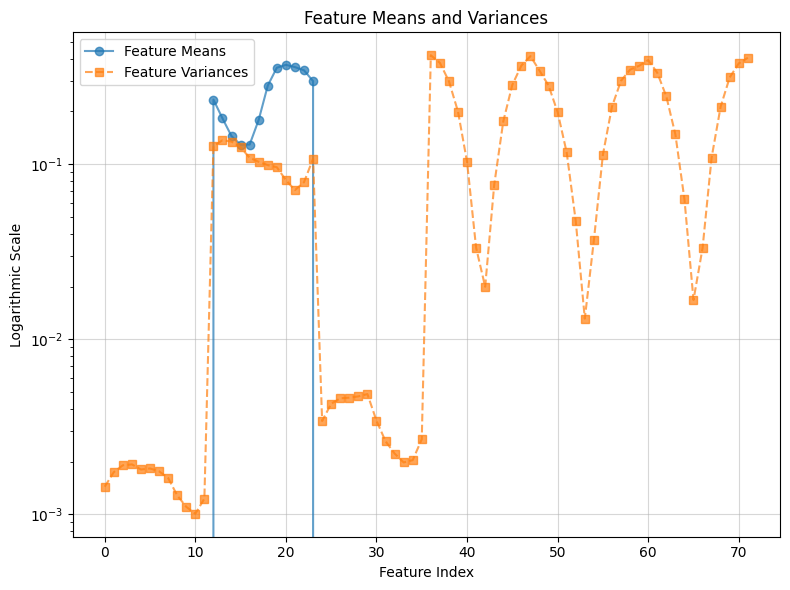

In [10]:
import matplotlib.pyplot as plt
GEP_means = torch.mean(GEP_X_scaled, axis=0)
GEP_vars = torch.var(GEP_X_scaled, axis=0)

# Plot the means and variances of all features on the same figure with a logarithmic Y-axis
plt.figure(figsize=(8, 6))
plt.plot(GEP_means, label='Feature Means', marker='o', linestyle='-', alpha=0.7)
plt.plot(GEP_vars, label='Feature Variances', marker='s', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.title('Feature Means and Variances')
plt.xlabel('Feature Index')
plt.ylabel('Logarithmic Scale')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

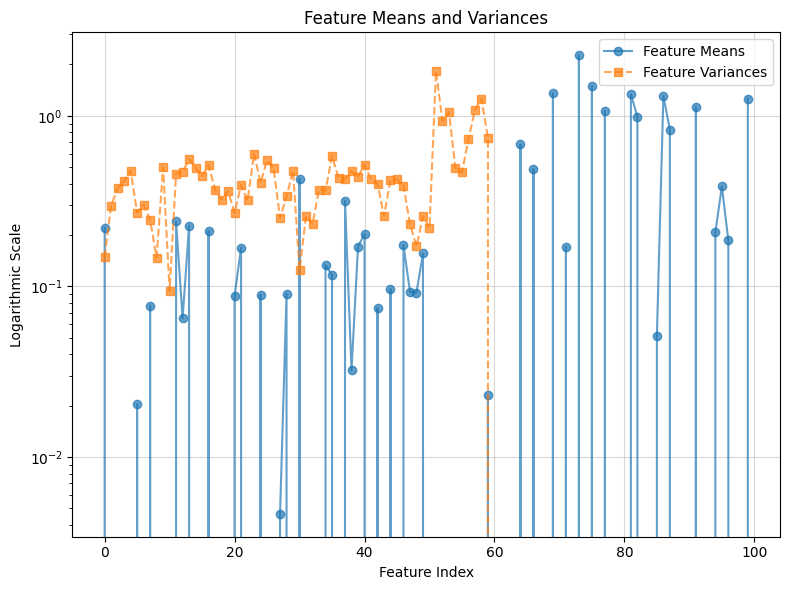

In [ ]:
QP_means = torch.mean(QP_X, axis=0)
QP_vars = torch.var(QP_X, axis=0)

# Plot the means and variances of all features on the same figure with a logarithmic Y-axis
plt.figure(figsize=(8, 6))
plt.plot(QP_means, label='Feature Means', marker='o', linestyle='-', alpha=0.7)
plt.plot(QP_vars, label='Feature Variances', marker='s', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.title('Feature Means and Variances')
plt.xlabel('Feature Index')
plt.ylabel('Logarithmic Scale')
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#    minimize_y 1/2 * y^T Q y + p^Ty
#    s.t.       Ay =  x
#               Gy <= h


#! See what happens when we make X more difficult.

X = QP_data.X
G = QP_data.G
h = QP_data.h
Q = QP_data.Q
p = QP_data.p
Y = QP_data.Y

print(Y.shape)
print(Q.shape)
print(p.shape)

print(X.shape)
print(G.shape)
print(h.shape)

torch.Size([10, 100])
torch.Size([100, 100])
torch.Size([100])
torch.Size([10, 50])
torch.Size([10, 50, 100])
torch.Size([10, 50])


In [ ]:
torch.concat([X, h], dim=1).shape

torch.Size([10, 100])

In [ ]:
G = QP_data.G[:, :1, :]
G_flattened = G.flatten(start_dim=1)
G_flattened.reshape(G.shape)

G_flattened.unsqueeze(1).shape

G[:, :1, :] = G_flattened.unsqueeze(1)